In [42]:
import torch
import torch.nn.functional as F
from torch.autograd import Function
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity
import gc
import time
import pandas as pd
import re
from collections import OrderedDict
from pathlib import Path

from zmq.backend.cffi import device


class ProblematicDropoutFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, keep_ratio=0.5):
        kept_cols = torch.rand(weight.size(1), device=input.device) < keep_ratio
        kept_cols = kept_cols.bool()

        input_reduced = input[:, kept_cols]
        weight_reduced = weight[:, kept_cols]

        ctx.save_for_backward(input_reduced, weight_reduced)
        ctx.kept_cols = kept_cols
        ctx.input_shape = input.shape
        ctx.weight_shape = weight.shape

        output = F.linear(input, weight)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input_reduced, weight_reduced = ctx.saved_tensors
        kept_cols = ctx.kept_cols

        grad_input_reduced = grad_output.mm(weight_reduced)
        grad_input = torch.zeros(ctx.input_shape, device=grad_output.device)
        grad_input[:, kept_cols] = grad_input_reduced

        grad_weight_reduced = grad_output.t().mm(input_reduced)
        grad_weight = torch.zeros(ctx.weight_shape, device=grad_output.device)
        grad_weight[:, kept_cols] = grad_weight_reduced

        return grad_input, grad_weight, None

class FixedDropoutFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, keep_ratio=0.5):

        # --- Full Forward Pass ---
        with torch.no_grad():
            output = F.linear(input, weight)

        # --- Memory-Saving "Backdrop" ---
        # Now, create the reduced tensors that you will need for the backward pass.
        num_cols_to_keep = int(weight.size(1) * keep_ratio)
        kept_cols_indices = torch.randperm(weight.size(1), device=input.device)[:num_cols_to_keep]

        input_reduced = input[:, kept_cols_indices]

        # Save only the reduced input and other necessary components.
        # We also need the original weight to recompute the reduced weight in backward.
        ctx.save_for_backward(input_reduced, weight)
        ctx.kept_cols_indices = kept_cols_indices
        ctx.input_shape = input.shape # Needed for reconstructing grad_input

        return output


    @staticmethod
    def backward(ctx, grad_output):

        if not ctx.needs_input_grad[0] and not ctx.needs_input_grad[1]:
            return None, None, None

        input_reduced, weight = ctx.saved_tensors
        kept_cols_indices = ctx.kept_cols_indices
        grad_input = grad_weight = None

        # --- Recomputation Step ---
        # Re-create the reduced weight tensor on-the-fly.
        weight_reduced = weight[:, kept_cols_indices]

        # --- Gradient Calculation ---
        # Now, compute gradients using the reduced tensors.
        if ctx.needs_input_grad[1]: # Gradient for weight
            grad_weight_reduced = grad_output.t().mm(input_reduced)
            grad_weight = torch.zeros_like(weight)
            grad_weight[:, kept_cols_indices] = grad_weight_reduced

        if ctx.needs_input_grad[0]: # Gradient for input
            grad_input_reduced = grad_output.mm(weight_reduced)
            grad_input = torch.zeros(ctx.input_shape, device=grad_output.device)
            grad_input[:, kept_cols_indices] = grad_input_reduced

        return grad_input, grad_weight, None


class SimpleTestModel(nn.Module):
    # The 'use_backdrop' argument is now correctly included in the constructor
    def __init__(self, input_dim, hidden_dim, output_dim, keep_ratio=0.5, use_backdrop=False, device='cpu'):
        super().__init__()
        self.keep_ratio = keep_ratio
        self.use_backdrop = use_backdrop

        if not self.use_backdrop:
            self.layer1 = nn.Linear(input_dim, hidden_dim).to(device)
            self.layer2 = nn.Linear(hidden_dim, output_dim).to(device)
        else:
            # Using nn.Parameter for the custom backdrop layers
            self.weight1 = nn.Parameter(torch.randn(hidden_dim, input_dim, device=device))
            self.weight2 = nn.Parameter(torch.randn(output_dim, hidden_dim, device=device))

    def forward(self, x):
        with record_function("layer_1"):
            if not self.use_backdrop:
                x = self.layer1(x)
            else:
                x = FixedDropoutFunction.apply(x, self.weight1, self.keep_ratio)

        with record_function("activation"):
            x = F.relu(x)

        with record_function("layer_2"):
            if not self.use_backdrop:
                x = self.layer2(x)
            else:
                x = FixedDropoutFunction.apply(x, self.weight2, self.keep_ratio)
        return x

In [48]:
def profile_model(model, inputs, label, device):
    # Ensure all tensors for the training step are on the correct device
    model.to(device)
    inputs = inputs.to(device)

    # Use a simple loss function and optimizer for a realistic training step
    model.train()
    gc.collect()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    targets = torch.randint(0, 10, (inputs.shape[0],), device=device)

    # --- UPDATED TRACE HANDLER ---
    # Define the trace handler to save both the Chrome trace and the memory timeline
    def trace_handler(p):
        # Export the standard Chrome trace for operator/kernel timelines
        chrome_trace_filename = f"./{label}_trace.json"
        p.export_chrome_trace(chrome_trace_filename)
        print(f"\nTrace for '{label}' saved to {chrome_trace_filename}")

        # Export the memory timeline to a separate HTML file [11]
        memory_timeline_filename = f"./{label}_memory_timeline.html"
        p.export_memory_timeline(memory_timeline_filename, device=device)
        print(f"Memory timeline for '{label}' saved to {memory_timeline_filename}")

    # Configure and run the profiler
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True,
        record_shapes=True,
        with_stack=True,
        on_trace_ready=trace_handler
    ) as prof:
        for _ in range(2): # Run a couple of steps for warmup and profiling
            with record_function("forward_pass"):
                outputs = model(inputs)

            with record_function("loss_computation"):
                loss = loss_fn(outputs, targets)

            with record_function("backward_pass"):
                loss.backward()

            with record_function("optimizer_step"):
                optimizer.step()
                optimizer.zero_grad()

            prof.step() # Signal the profiler to record the step

Using device: cuda:1
Profiling standard nn.Linear model...

Trace for 'standard_model' saved to ./standard_model_trace.json
Memory timeline for 'standard_model' saved to ./standard_model_memory_timeline.html
\nProfiling Backdrop model...

Trace for 'backdrop_model' saved to ./backdrop_model_trace.json
Memory timeline for 'backdrop_model' saved to ./backdrop_model_memory_timeline.html


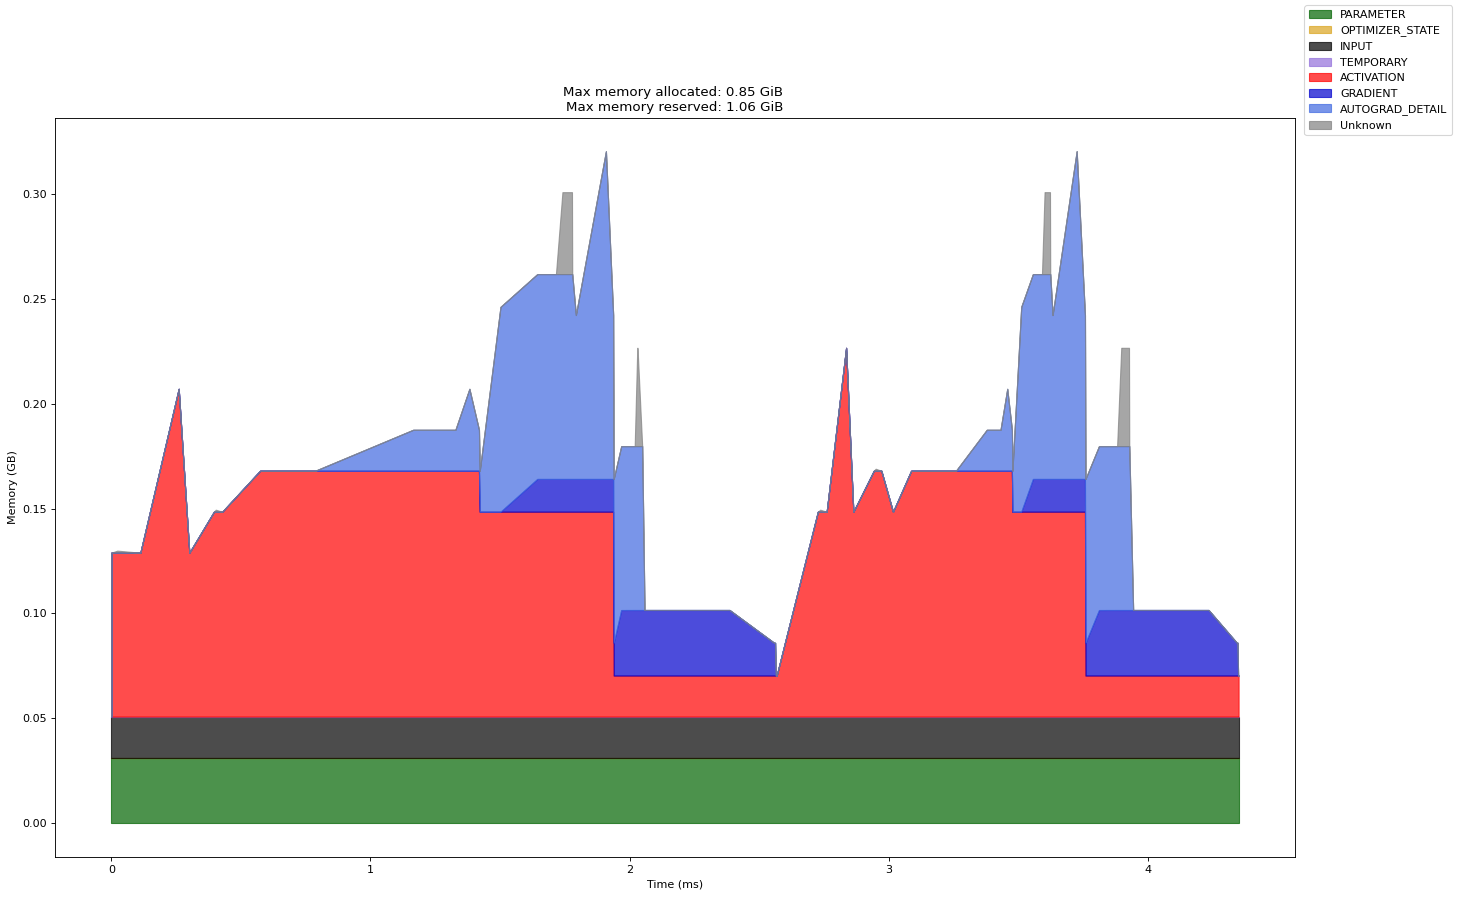

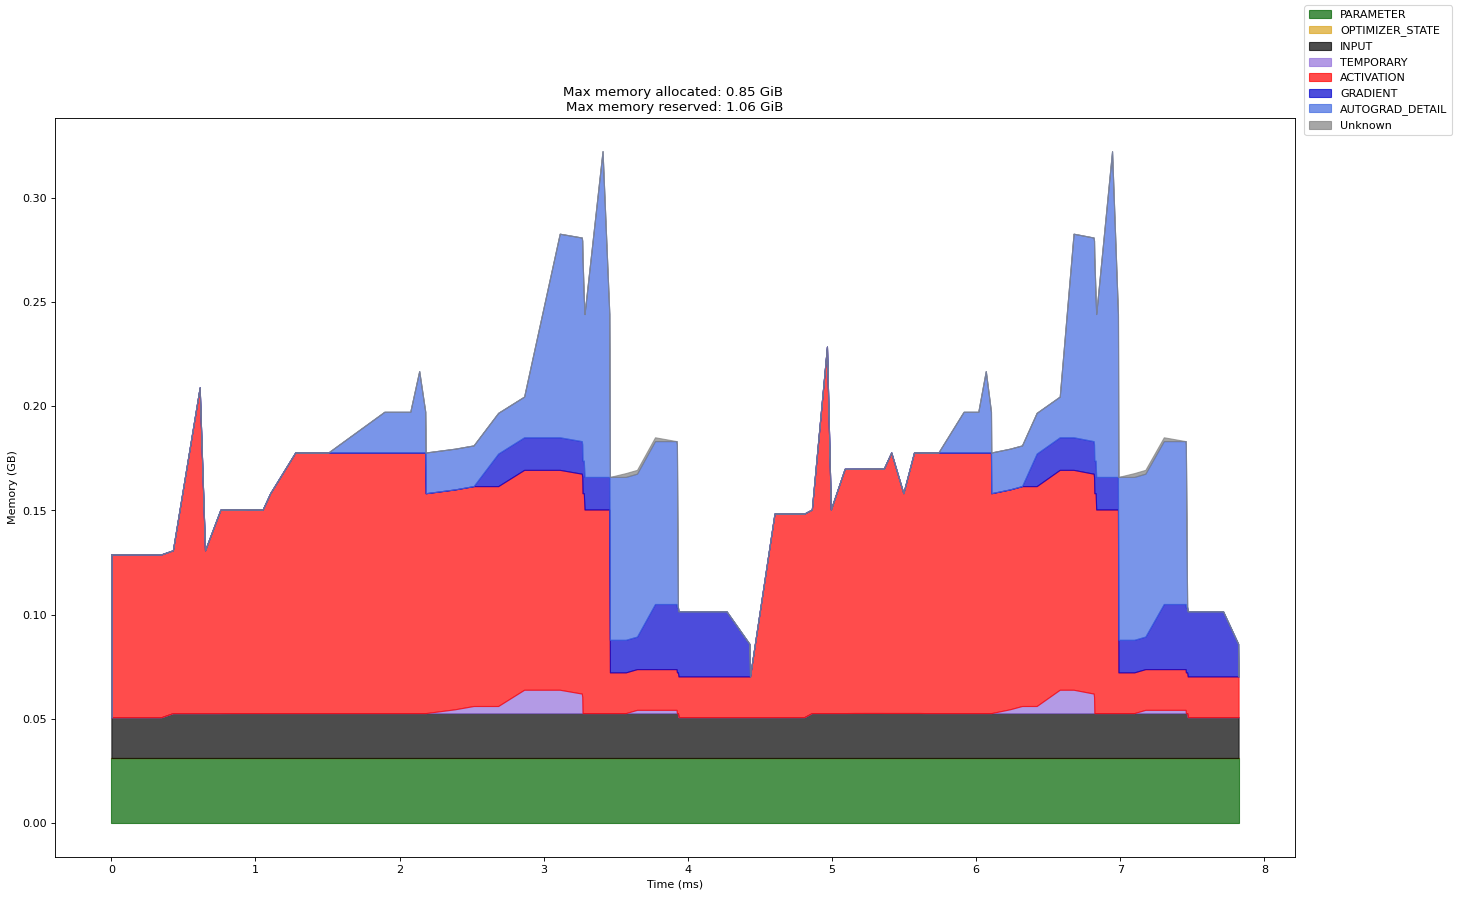

In [56]:
# --- Main Execution ---
if __name__ == "__main__":
    # Model parameters
    batch_size = 512
    input_dim = 1024
    hidden_dim = 4096
    output_dim = 1024
    keep_ratio = 0.1
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # --- Profile the standard model ---
    print("Profiling standard nn.Linear model...")
    standard_model = SimpleTestModel(input_dim, hidden_dim, output_dim, use_backdrop=False)
    inputs = torch.randn(batch_size, input_dim)
    profile_model(standard_model, inputs, "standard_model", device)

    # --- Profile the backdrop model ---
    print("\\nProfiling Backdrop model...")
    backdrop_model = SimpleTestModel(input_dim, hidden_dim, output_dim, keep_ratio=keep_ratio, use_backdrop=True)
    inputs = torch.randn(batch_size, input_dim)
    profile_model(backdrop_model, inputs, "backdrop_model", device)